#### Exercise 10 - Solution - Synthetic Control Using Lasso

An e-commerce company operating in 10 different regions implemented a new marketing strategy in a single test region (Region 5) starting October 1 2024 continuing indefinitely. As we've generated the data ourselves, we know the ground truth is that the treatment increased revenue in that region by 20% over what it would have been if not for the change. 

Your goal is to build a synthetic control model that reasonably reflects this increase. 

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
import statsmodels.formula.api as smf 


In [11]:
df = pd.read_csv("../data/synthetic_control_revenue_data.csv", date_parser=True)
df.head()

/var/folders/f0/jvljfjlj3bxdhpqmfbcnfsbm0000gn/T/ipykernel_26682/1772449537.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv("../data/synthetic_control_revenue_data.csv", date_parser=True)


,Month,Region 1,Region 2,Region 3,Region 4,Region 5,Region 6,Region 7,Region 8,Region 9,Region 10
0,2023-01-01,9322.565026,10763.201411,8379.885931,9258.455623,9450.947929,10437.677905,10060.643647,9985.189491,9328.222526,9639.947623
1,2023-02-01,9737.938268,11701.398724,11241.961029,10991.843109,10222.822882,10700.643686,10281.504076,10915.543547,10560.931888,11581.508977
2,2023-03-01,11287.917691,11792.099443,11363.351753,9207.389538,10847.371295,11319.571857,12205.977940,12243.919931,10102.988763,11022.111375
3,2023-04-01,12584.751131,12967.746822,12867.541821,11259.416674,11975.964764,12603.817098,11528.820985,11631.156162,11660.287992,12052.554474
4,2023-05-01,11816.404647,11426.054667,11258.764335,11598.348889,11540.803870,12154.049899,10765.484396,12401.222295,11194.799213,11972.444224


In [12]:
# Set parameters 
treated_region = "Region 5"
control_regions = [col for col in df.columns if col.startswith("Region") and col != treated_region]
event_start = "2024-10-01" 


In [13]:
# Estimate a Lasso regression model using pre-treatment data 
preperiod = df[df["Month"] < event_start] 

lasso_model = Lasso(alpha=0.1).fit(preperiod[control_regions], preperiod[treated_region])

# Get the coefficients from the Lasso model
lasso_coefficients = pd.Series(lasso_model.coef_, index=control_regions)
print(lasso_coefficients)

Region 1     0.499687
Region 2    -0.000435
Region 3    -0.000255
Region 4     0.299986
Region 6     0.000146
Region 7     0.200144
Region 8     0.000251
Region 9     0.000365
Region 10    0.000174
dtype: float64


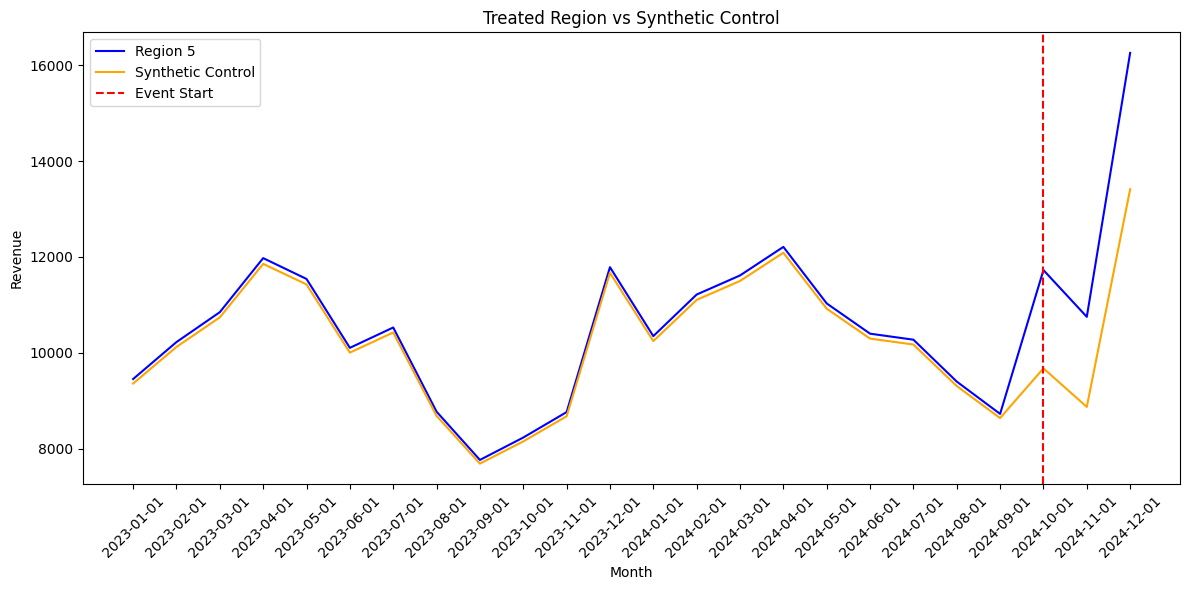

In [14]:
# Use the coefficients to estimate the synthetic control for the entire period 

df["Synthetic Control"] = df[control_regions].dot(lasso_coefficients)

offset_for_plot = 0.99

# Plot the treated region and synthetic control
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(df["Month"], df[treated_region], label=treated_region, color='blue')
plt.plot(df["Month"], df["Synthetic Control"]*offset_for_plot, label="Synthetic Control", color='orange')
plt.axvline(event_start, color='red', linestyle='--', label='Event Start')
plt.title("Treated Region vs Synthetic Control")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [18]:
# Estimate the treatment effect by comparing the treated region to the synthetic control
df["Treatment Effect"] = df[treated_region] - df["Synthetic Control"]

postperiod = df[df["Month"] >= event_start]
print("Post-treatment period treatment effect:")
print(postperiod["Treatment Effect"].mean())
print(postperiod["Treatment Effect"].mean() / (postperiod["Synthetic Control"].mean()))


Post-treatment period treatment effect:
2152.322446426575
0.2000256712998919
